# Predicting Boston Housing Prices

## Using XGBoost in SageMaker (Hyperparameter Tuning)

_Deep Learning Nanodegree Program | Deployment_

---

As an introduction to using SageMaker's Low Level API for hyperparameter tuning, we will look again at the [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) to predict the median value of a home in the area of Boston Mass.

The documentation reference for the API used in this notebook is the [SageMaker Developer's Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/)

## General Outline

Typically, when using a notebook instance with SageMaker, you will proceed through the following steps. Of course, not every step will need to be done with each project. Also, there is quite a lot of room for variation in many of the steps, as you will see throughout these lessons.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

In this notebook we will only be covering steps 1 through 5 as we are only interested in creating a tuned model and testing its performance.

## Step 0: Setting up the notebook

We begin by setting up all of the necessary bits required to run our notebook. To start that means loading all of the Python modules we will need.

In [1]:
%matplotlib inline

import os

import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In addition to the modules above, we need to import the various bits of SageMaker that we will be using. 

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## Step 1: Downloading the data

Fortunately, this dataset can be retrieved using sklearn and so this step is relatively straightforward.

In [3]:
boston = load_boston()

## Step 2: Preparing and splitting the data

Given that this is clean tabular data, we don't need to do any processing. However, we do need to split the rows in the dataset up into train, test and validation sets.

In [4]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Step 3: Uploading the data files to S3

When a training job is constructed using SageMaker, a container is executed which performs the training operation. This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3. We can use the SageMaker API to do this and hide some of the details.

### Save the data locally

First we need to create the test, train and validation csv files which we will then upload to S3.

In [5]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
# We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload to S3

Since we are currently running inside of a SageMaker session, we can use the object which represents this session to upload our data to the 'default' S3 bucket. Note that it is good practice to provide a custom prefix (essentially an S3 folder) to make sure that you don't accidentally interfere with data uploaded from some other notebook or project.

In [7]:
prefix = 'boston-xgboost-tuning-LL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Step 4: Train and construct the XGBoost model

Now that we have the training and validation data uploaded to S3, we can construct our XGBoost model and train it. Unlike in the previous notebooks, instead of training a single model, we will use SageMakers hyperparameter tuning functionality to train multiple models and use the one that performs the best on the validation set.

### Set up the training job

First, we will set up a training job for our model. This is very similar to the way in which we constructed the training job in previous notebooks. Essentially this describes the *base* training job from which SageMaker will create refinements by changing some hyperparameters during the hyperparameter tuning job.

In [8]:
# We will need to know the name of the container that we want to use for training. SageMaker provides
# a nice utility method to construct this for us.
container = get_image_uri(session.boto_region_name, 'xgboost')

# We now specify the parameters we wish to use for our training job
training_params = {}

# We need to specify the permissions that this training job will have. For our purposes we can use
# the same permissions that our current SageMaker session has.
training_params['RoleArn'] = role

# Here we describe the algorithm we wish to use. The most important part is the container which
# contains the training code.
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# We also need to say where we would like the resulting model artifacts stored.
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# We also need to set some parameters for the training job itself. Namely we need to describe what sort of
# compute instance we wish to use along with a stopping condition to handle the case that there is
# some sort of error and the training script doesn't terminate.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {
    "MaxRuntimeInSeconds": 86400
}

# Next we set the algorithm specific hyperparameters. In this case, since we are setting up
# a training job which will serve as the base training job for the eventual hyperparameter
# tuning job, we only specify the _static_ hyperparameters. That is, the hyperparameters that
# we do _not_ want SageMaker to change.
training_params['StaticHyperParameters'] = {
    "gamma": "4",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# Now we need to tell SageMaker where the data should be retrieved from.
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

### Set up the tuning job

Now that the *base* training job has been set up, we can describe the tuning job that we would like SageMaker to perform. In particular, like in the high level notebook, we will specify which hyperparameters we wish SageMaker to change and what range of values they may take on.

In addition, we specify the *number* of models to construct (`max_jobs`) and the number of those that can be trained in parallel (`max_parallel_jobs`). In the cell below we have chosen to train `20` models, of which we ask that SageMaker train `3` at a time in parallel. Note that this results in a total of `20` training jobs being executed which can take some time, in this case almost a half hour. With more complicated models this can take even longer so be aware!

In [9]:
# We need to construct a dictionary which specifies the tuning job we want SageMaker to perform
tuning_job_config = {
    # First we specify which hyperparameters we want SageMaker to be able to vary,
    # and we specify the type and range of the hyperparameters.
    "ParameterRanges": {
    "CategoricalParameterRanges": [],
    "ContinuousParameterRanges": [
        {
            "MaxValue": "0.5",
            "MinValue": "0.05",
            "Name": "eta"
        },
    ],
    "IntegerParameterRanges": [
        {
            "MaxValue": "12",
            "MinValue": "3",
            "Name": "max_depth"
        },
        {
            "MaxValue": "8",
            "MinValue": "2",
            "Name": "min_child_weight"
        }
    ]},
    # We also need to specify how many models should be fit and how many can be fit in parallel
    "ResourceLimits": {
        "MaxNumberOfTrainingJobs": 20,
        "MaxParallelTrainingJobs": 3
    },
    # Here we specify how SageMaker should update the hyperparameters as new models are fit
    "Strategy": "Bayesian",
    # And lastly we need to specify how we'd like to determine which models are better or worse
    "HyperParameterTuningJobObjective": {
        "MetricName": "validation:rmse",
        "Type": "Minimize"
    }
  }

### Execute the tuning job

Now that we've built the data structures that describe the tuning job we want SageMaker to execute, it is time to actually start the job.

In [10]:
# First we need to choose a name for the job. This is useful for if we want to recall information about our
# tuning job at a later date. Note that SageMaker requires a tuning job name and that the name needs to
# be unique, which we accomplish by appending the current timestamp.
tuning_job_name = "tuning-job" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# And now we ask SageMaker to create (and execute) the training job
session.sagemaker_client.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                                           HyperParameterTuningJobConfig = tuning_job_config,
                                                           TrainingJobDefinition = training_params)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:eu-west-1:177473201433:hyper-parameter-tuning-job/tuning-job2019-01-15-15-20-30',
 'ResponseMetadata': {'RequestId': '2d8f8a74-9ac2-4aed-8c27-ecfcc6101311',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2d8f8a74-9ac2-4aed-8c27-ecfcc6101311',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Tue, 15 Jan 2019 15:20:29 GMT'},
  'RetryAttempts': 0}}

The tuning job has now been created by SageMaker and is currently running. Since we need the output of the tuning job, we may wish to wait until it has finished. We can do so by asking SageMaker to output the logs generated by the tuning job and continue doing so until the job terminates.

In [11]:
session.wait_for_tuning_job(tuning_job_name)

................................................................................................................................................................................................................................................................................!


{'HyperParameterTuningJobName': 'tuning-job2019-01-15-15-20-30',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:eu-west-1:177473201433:hyper-parameter-tuning-job/tuning-job2019-01-15-15-20-30',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'validation:rmse'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 20,
   'MaxParallelTrainingJobs': 3},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'max_depth',
     'MinValue': '3',
     'MaxValue': '12'},
    {'Name': 'min_child_weight', 'MinValue': '2', 'MaxValue': '8'}],
   'ContinuousParameterRanges': [{'Name': 'eta',
     'MinValue': '0.05',
     'MaxValue': '0.5'}],
   'CategoricalParameterRanges': []}},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'validation:rmse',
   'early_stopping_rounds': '10',
   'gamma': '4',
   'num_round': '200',
   'objective': 'reg:linear',
   'subsample': '0.8'},
  'Algori

### Build the model

Now that the tuning job has finished, SageMaker has fit a number of models, the results of which are stored in a data structure which we can access using the name of the tuning job.

In [12]:
tuning_job_info = session.sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

Among the pieces of information included in the `tuning_job_info` object is the name of the training job which performed best out of all of the models that SageMaker fit to our data. Using this training job name we can get access to the resulting model artifacts, from which we can construct a model.

In [13]:
# We begin by asking SageMaker to describe for us the results of the best training job. The data
# structure returned contains a lot more information than we currently need, try checking it out
# yourself in more detail.
best_training_job_name = tuning_job_info['BestTrainingJob']['TrainingJobName']
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=best_training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [14]:
# Just like when we created a training job, the model name must be unique
model_name = best_training_job_name + "-model"

# We also need to tell SageMaker which container should be used for inference and where it should
# retrieve the model artifacts from. In our case, the xgboost container that we used for training
# can also be used for inference.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# And lastly we construct the SageMaker model
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

## Step 5: Testing the model

Now that we have fit our model to the training data, using the validation data to avoid overfitting, we can test our model. To do this we will make use of SageMaker's Batch Transform functionality. In other words, we need to set up and execute a batch transform job, similar to the way that we constructed the training job earlier.

### Set up the batch transform job

Just like when we were training our model, we first need to provide some information in the form of a data structure that describes the batch transform job which we wish to execute.

We will only be using some of the options available here but to see some of the additional options please see the SageMaker documentation for [creating a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTransformJob.html).

In [15]:
# Just like in each of the previous steps, we need to make sure to name our job and the name should be unique.
transform_job_name = 'boston-xgboost-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# Now we construct the data structure which will describe the batch transform job.
transform_request = \
{
    "TransformJobName": transform_job_name,
    
    # This is the name of the model that we created earlier.
    "ModelName": model_name,
    
    # This describes how many compute instances should be used at once. If you happen to be doing a very large
    # batch transform job it may be worth running multiple compute instances at once.
    "MaxConcurrentTransforms": 1,
    
    # This says how big each individual request sent to the model should be, at most. One of the things that
    # SageMaker does in the background is to split our data up into chunks so that each chunks stays under
    # this size limit.
    "MaxPayloadInMB": 6,
    
    # Sometimes we may want to send only a single sample to our endpoint at a time, however in this case each of
    # the chunks that we send should contain multiple samples of our input data.
    "BatchStrategy": "MultiRecord",
    
    # This next object describes where the output data should be stored. Some of the more advanced options which
    # we don't cover here also describe how SageMaker should collect output from various batches.
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)
    },
    
    # Here we describe our input data. Of course, we need to tell SageMaker where on S3 our input data is stored, in
    # addition we need to detail the characteristics of our input data. In particular, since SageMaker may need to
    # split our data up into chunks, it needs to know how the individual samples in our data file appear. In our
    # case each line is its own sample and so we set the split type to 'line'. We also need to tell SageMaker what
    # type of data is being sent, in this case csv, so that it can properly serialize the data.
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },
    
    # And lastly we tell SageMaker what sort of compute instance we would like it to use.
    "TransformResources": {
            "InstanceType": "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

### Execute the batch transform job

Now that we have created the request data structure, it is time to as SageMaker to set up and run our batch transform job. Just like in the previous steps, SageMaker performs these tasks in the background so that if we want to wait for the transform job to terminate (and ensure the job is progressing) we can ask SageMaker to wait of the transform job to complete.

In [16]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)

In [17]:
transform_desc = session.wait_for_transform_job(transform_job_name)

.....................................!


### Analyze the results

Now that the transform job has completed, the results are stored on S3 as we requested. Since we'd like to do a bit of analysis in the notebook we can use some notebook magic to copy the resulting output from S3 and save it locally.

In [18]:
transform_output = "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)

In [19]:
!aws s3 cp --recursive $transform_output $data_dir

download: s3://sagemaker-eu-west-1-177473201433/boston-xgboost-tuning-LL/batch-bransform/test.csv.out to ../data/boston/test.csv.out


To see how well our model works we can create a simple scatter plot between the predicted and actual values. If the model was completely accurate the resulting scatter plot would look like the line $x=y$. As we can see, our model seems to have done okay but there is room for improvement.

In [20]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5,1,'Median Price vs Predicted Price')

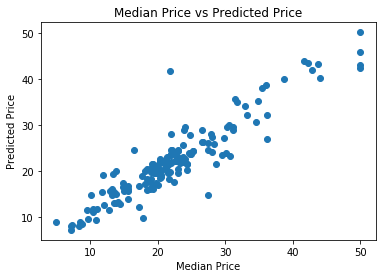

In [21]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Optional: Clean up

The default notebook instance on SageMaker doesn't have a lot of excess disk space available. As you continue to complete and execute notebooks you will eventually fill up this disk space, leading to errors which can be difficult to diagnose. Once you are completely finished using a notebook it is a good idea to remove the files that you created along the way. Of course, you can do this from the terminal or from the notebook hub if you would like. The cell below contains some commands to clean up the created files from within the notebook.

In [22]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir